In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2
!pip install imbalanced-learn==0.11.0

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.5 MB/s eta 0:00:00:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 9.3 MB/s eta 0:00:00


In [4]:
transactions_csv = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")

In [5]:
identity_csv = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

In [6]:
transactions_csv = transactions_csv.merge(identity_csv, on='TransactionID', how='left')

In [7]:
pd.set_option('display.max_columns', None)

In [182]:
transactions_csv.head(20)
transactions_csv.isna().mean()["P_emaildomain"]

0.1599485216920107

In [8]:
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import shap


X = transactions_csv.drop(columns=["isFraud"])
y = transactions_csv["isFraud"]

user_proxy = (
    X['card1'].astype(str) + '_' +
    X['addr1'].astype(str) + '_' +
    X['P_emaildomain'].astype(str)
)

# First split: 80% train+val, 20% test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(gss.split(X, y, groups=user_proxy))

X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
user_proxy_train_val = user_proxy.iloc[train_val_idx]

# Second split: 75% train, 25% validation
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(gss_val.split(X_train_val, y_train_val, groups=user_proxy_train_val))

X_train = X_train_val.iloc[train_idx]
X_val = X_train_val.iloc[val_idx]
y_train = y_train_val.iloc[train_idx]
y_val = y_train_val.iloc[val_idx]

X_train = X_train.drop(columns=["TransactionID"])
X_val = X_val.drop(columns=["TransactionID"])
X_test = X_test.drop(columns=["TransactionID"])

X_train_saved = X_train.copy()
X_val_saved = X_val.copy()
X_test_saved = X_test.copy()

In [ ]:
y_train.sum()/60

In [ ]:
y_val.sum()/20

In [187]:
y_test.sum()/20

203.05

In [188]:
mean = (y_train.sum()/60 + y_val.sum()/20 + y_test.sum()/20) / 3

In [189]:
mean

205.7166666666667

In [190]:
abs(y_train.sum()/60 - mean) + abs(y_val.sum()/20 - mean) + abs(y_test.sum()/20 - mean)

5.333333333333286

In [9]:
na_cols_to_drop = X_train.isna().mean()[X_train.isna().mean() > 0.8].index

In [10]:
print(na_cols_to_drop)

Index(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
       'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
       'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
       'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
       'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18',
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30',
       'id_32', 'id_33', 'id_34'],
      dtype='object')


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
class ModeImputer(BaseEstimator, TransformerMixin):

    
    def fit(self, X, y=None):
        X_temp = X.copy()
        self.modes = X_temp.mode().iloc[0]
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            X_transformed[col] = X_transformed[col].fillna(self.modes[col])
        return X_transformed

In [12]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

In [13]:
X_train.shape

(358445, 432)

In [13]:
ColumnDropper(na_cols_to_drop).fit_transform(X_train, y_train)

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,

In [14]:
X_train.shape

(358445, 432)

In [14]:
cleaning_pipeline = Pipeline(steps=[
    ("na_cols_dropper",ColumnDropper(na_cols_to_drop)),
    ("na_cols_mode_imputer", ModeImputer())
])

In [15]:
cleaning_pipeline.fit(X_train, y_train)

Pipeline(steps=[('na_cols_dropper',
                 ColumnDropper(columns_to_drop=Index(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
       'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
       'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
       'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
       'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18',
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30',
       'id_32', 'id_33', 'id_34'],
      dtype='object'))),
                ('na_cols_mode_imputer', ModeImputer())])

In [16]:
X_train = cleaning_pipeline.transform(X_train)
X_test = cleaning_pipeline.transform(X_test)

In [17]:
X_train.isna().mean().sum()

0.0

In [18]:
X_test.isna().mean().sum()

0.0

In [19]:
!pip install dagshub mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 26.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

In [22]:
import dagshub 
import mlflow
dagshub.init(repo_owner='Luka-Surmanidze', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ff059a5f-435c-4183-aa96-1350b33bd6d8&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=b3488530d18763de6013437c0a45fcf09ba9cec80a146f32aa0a1bc6835f56d5




Accessing as Luka-Surmanidze

Initialized MLflow to track repo "Luka-Surmanidze/IEEE-CIS-Fraud-Detection"

Repository Luka-Surmanidze/IEEE-CIS-Fraud-Detection initialized!

In [202]:
# experiment_name = "Logistic Regression L2"

In [203]:
# mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/9361fa02532c4aea865695b737a1c285', creation_time=1744911588602, experiment_id='0', last_update_time=1744911588602, lifecycle_stage='active', name='Logistic Regression L2', tags={}>

In [218]:
# run_name = "LogisticRegression_cleaningV3"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Cleaning")
# mlflow.log_param("Na columns default impute method", "ModeImputing")
# mlflow.log_param("Dropping NA columns default threshold", 0.8)

# mlflow.sklearn.log_model(cleaning_pipeline, "cleaning_pipeline")
# mlflow.end_run()

2025/04/22 11:08:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/22 11:08:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_cleaningV3 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/44da463e971c43b4a8b27ee2eeb486e4
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [23]:
col = "id_31_woe"
size = len(col)

dash_idx = -1

for i in range(size):
    if(col[size - i - 1] == '_'):
        dash_idx = size - i - 1
        print(f"found dash index - {size - i - 1}")
        break

first_half = col[0:dash_idx]
second_half = col[dash_idx + 1:]
print(first_half)
print(second_half)

found dash index - 5
id_31
woe


In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, woe_columns, one_hot_columns):
        self.woe_columns = woe_columns # Columns Which Should Be Preprocessed Using WOE
        self.one_hot_columns = one_hot_columns # Columns Which Should Be Preprocessed Using One Hot Encoder

    def fit(self, X, y):
        # Generate Fill Na Values Just in Case
        self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()
        
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values

        return self


    def transform(self, X):
        X_transformed = X.copy()

        # Preprocess WOE Columns
        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)

        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=False, dtype=int)

        n = X_transformed.isna().mean()

        na_cols = list(n[n > 0].index)

        # print(f"na cols - {na_cols}")
        for col in na_cols:
            size = len(col)
            for i in range(size):
                if(col[size - i - 1] == '_'):
                    dash_idx = size - i - 1
                    print(f"found dash index - {size - i - 1}")
                    break
            
            name = col[0:dash_idx]
            pr = col[dash_idx + 1:]
            
            # print(f"inside for loop with col {col}")
            # name, pr = col.split("_")
            if pr != "woe":
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])
            
        return X_transformed

In [25]:
cat_cols = X_train.dtypes[X_train.dtypes == "object"].index

In [26]:
unique_vals = X_train[cat_cols].nunique()

In [27]:
one_hot_cols = unique_vals[(unique_vals[cat_cols] < 4)].index.tolist()

In [28]:
woe_cols = unique_vals[(unique_vals[cat_cols] > 3)].index.tolist()

In [29]:
one_hot_cols

['M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

In [30]:
woe_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_31',
 'DeviceInfo']

In [31]:
pre = CategoricalPreprocessor(woe_cols, one_hot_cols)

In [32]:
temp = pre.fit_transform(X_train, y_train)

In [33]:
engineering_pipeline = Pipeline(steps=[
    ("CategoricalPreprocessor", CategoricalPreprocessor(woe_cols, one_hot_cols))
])

In [34]:
engineering_pipeline.fit(X_train, y_train)

Pipeline(steps=[('CategoricalPreprocessor',
                 CategoricalPreprocessor(one_hot_columns=['M1', 'M2', 'M3',
                                                          'M4', 'M5', 'M6',
                                                          'M7', 'M8', 'M9',
                                                          'id_12', 'id_15',
                                                          'id_16', 'id_28',
                                                          'id_29', 'id_35',
                                                          'id_36', 'id_37',
                                                          'id_38',
                                                          'DeviceType'],
                                         woe_columns=['ProductCD', 'card4',
                                                      'card6', 'P_emaildomain',
                                                      'R_emaildomain', 'id_31',
                                                      'DeviceInfo']))])

In [35]:
X_train = engineering_pipeline.transform(X_train)

In [36]:
X_test = engineering_pipeline.transform(X_test)

found dash index - 5
found dash index - 10


In [217]:
# run_name = "LogisticRegression_feature_engineeringV3"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Feature Engineering")
# mlflow.log_param("categorical_encoding_technique_1", "woe_encoding")
# mlflow.log_param("categorical_encoding_technique_2", "one_hot_encoding")

# mlflow.log_param("woe_cols_size", len(woe_cols))
# mlflow.log_param("one_hot_cols_size", len(one_hot_cols))

# mlflow.log_param("default_threshold_for_one_hot_cols", 3)

# mlflow.sklearn.log_model(engineering_pipeline, "engineering_pipeline")
# mlflow.end_run()

2025/04/22 11:06:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/22 11:06:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_feature_engineeringV3 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/88d53b77e45247fabe761ca574d0ac2f
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [37]:
X_train_corr = X_train.corr()

invalid value encountered in less


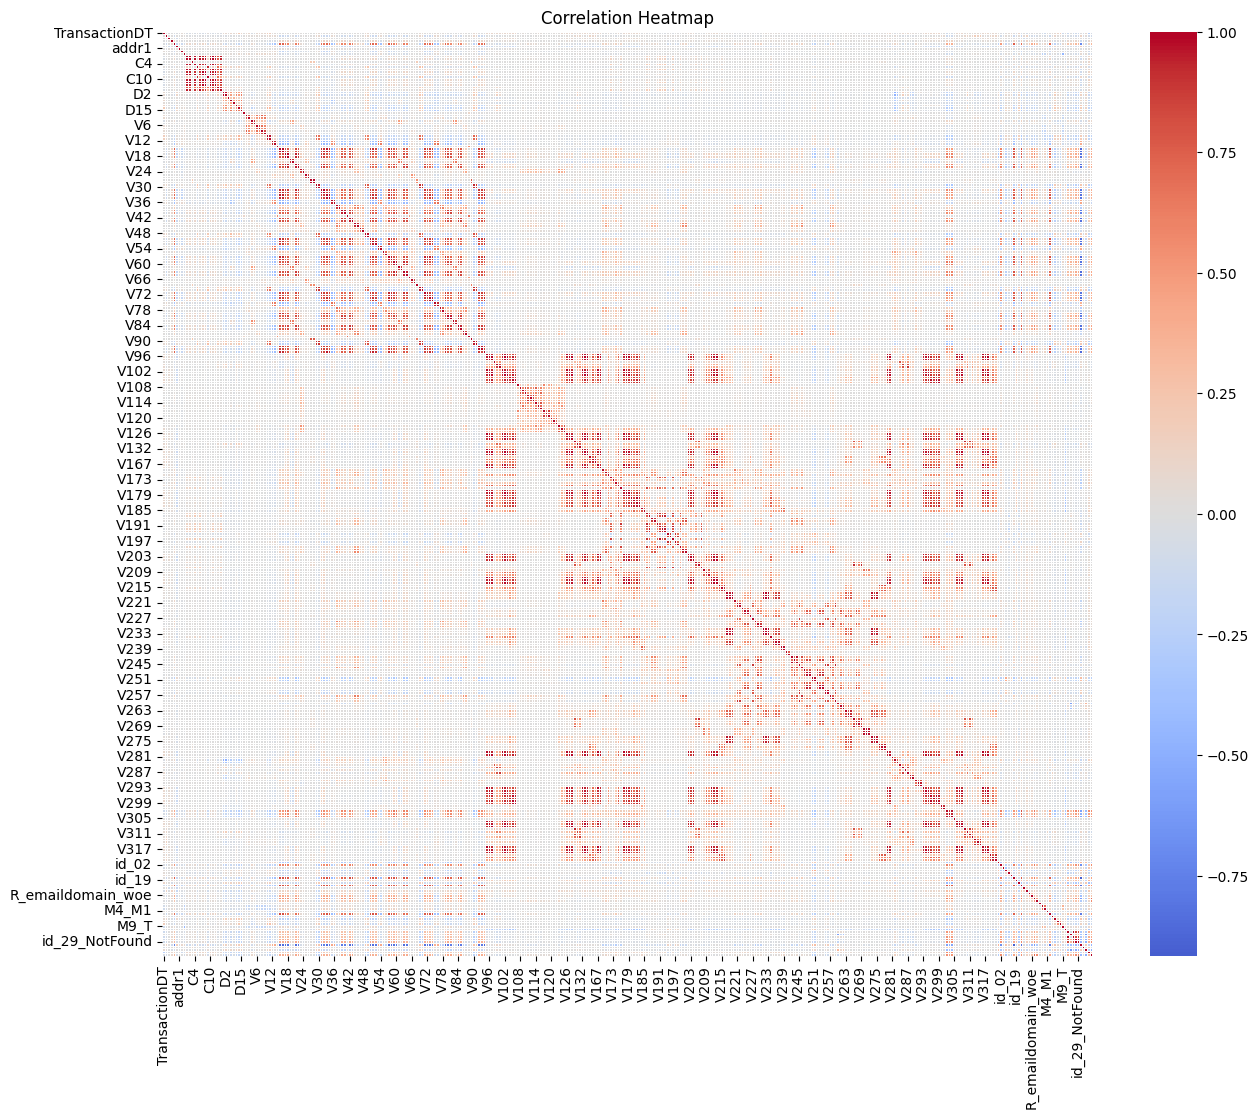

In [220]:
plt.figure(figsize=(15, 12))
sns.heatmap(X_train_corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap')

# Save the figure BEFORE showing it
corr_artifact_path = "correlation_heatmap.png"
plt.savefig(corr_artifact_path)

# Only show if you need to see it in the notebook
plt.show()  

# Close the figure
plt.close()

In [221]:
corr_matrix = X_train_corr.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 2. Compute correlation with target
target_corr = X_train.corrwith(y_train).abs()

# 3. Track features to drop
to_drop = set()

# 4. Iterate through high-correlation pairs
for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > 0.9:
            # Compare target correlations and drop the weaker one
            if target_corr[row] < target_corr[col]:
                to_drop.add(row)
            else:
                to_drop.add(col)

# 5. Drop selected features
                
# X_train_reduced = X_train.drop(columns=to_drop)

In [222]:
print(to_drop)

{'V180', 'V299', 'V15', 'V178', 'V269', 'V264', 'V127', 'V168', 'V57', 'V306', 'V59', 'V318', 'V51', 'V255', 'V246', 'V16', 'V179', 'V307', 'V21', 'V69', 'V167', 'V29', 'V204', 'V101', 'V54', 'V259', 'V237', 'V211', 'V193', 'V231', 'V4', 'V274', 'V64', 'V195', 'V242', 'V133', 'V272', 'V94', 'V19', 'V92', 'V319', 'V132', 'V27', 'V270', 'V308', 'V177', 'V313', 'V36', 'V72', 'V39', 'V106', 'V316', 'V232', 'V278', 'V80', 'V190', 'V213', 'V253', 'V200', 'V293', 'V291', 'V192', 'V32', 'V76', 'V113', 'V102', 'V221', 'C10', 'V202', 'C1', 'V134', 'V275', 'V294', 'D1', 'V321', 'C11', 'V273', 'V71', 'V13', 'V304', 'id_29_NotFound', 'V303', 'C14', 'V238', 'V105', 'V17', 'V298', 'V317', 'V176', 'C5', 'C8', 'V212', 'V84', 'V31', 'V93', 'V248', 'V233', 'V203', 'V254', 'V280', 'V182', 'V251', 'V128', 'V11', 'V70', 'V34', 'V297', 'V30', 'V216', 'V263', 'V103', 'V91', 'V97', 'V73', 'V126', 'V183', 'V49', 'V236', 'V245', 'id_17', 'V60', 'V129', 'C6', 'C4', 'V219', 'V42', 'V196', 'V224', 'V22', 'id_16_Not

In [223]:
X_train_filtered = X_train.drop(columns=to_drop)

In [224]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)

selector.fit(X_train_filtered)

high_variance_cols = X_train_filtered.columns[selector.get_support()]
low_variance_cols = X_train_filtered.columns[~selector.get_support()]
X_train_var_filtered = X_train_filtered[high_variance_cols]

In [225]:
low_variance_cols

Index(['V1', 'V14', 'V28', 'V41', 'V65', 'V68', 'V88', 'V89', 'V107', 'V108',
       'V110', 'V111', 'V112', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122',
       'V240', 'V241', 'V305', 'card4_woe', 'M1_T'],
      dtype='object')

In [226]:
(X_train_filtered.nunique() == 1).sum()

0

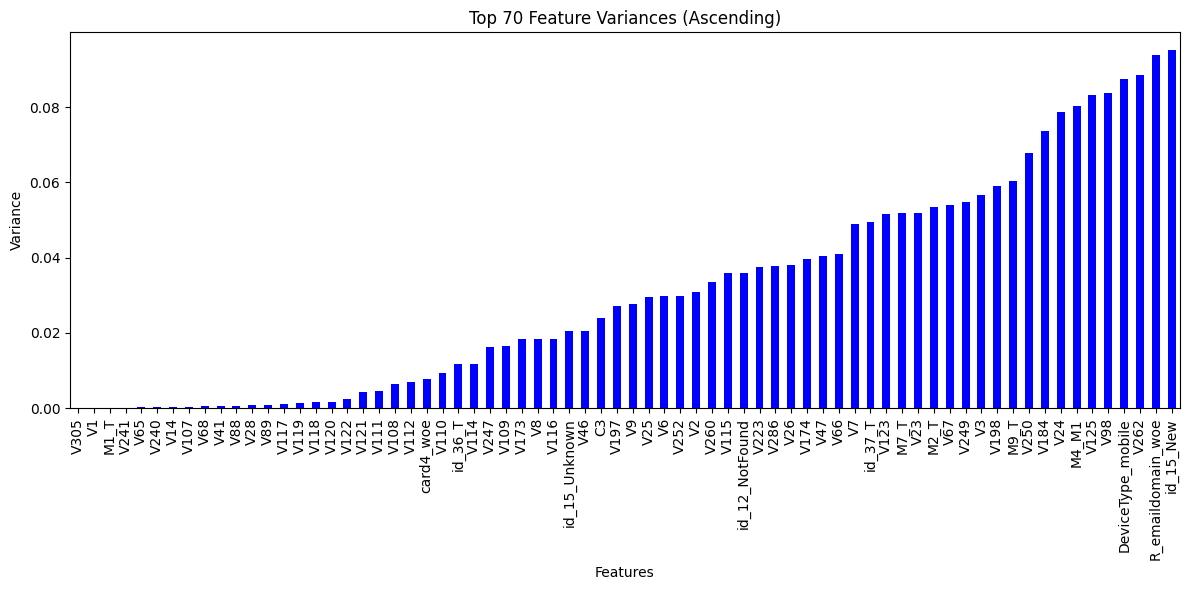

In [227]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute variance for each column
variances = X_train_filtered.var()

# Sort ascending and get top 70
top_70_variances = variances.sort_values(ascending=True).head(70)

# Plot
plt.figure(figsize=(12, 6))
top_70_variances.sort_values().plot(kind='bar', color='blue')
plt.title("Top 70 Feature Variances (Ascending)")
plt.ylabel("Variance")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [228]:
cols_to_remove = []
for corr_col in to_drop:
    cols_to_remove.append(corr_col)


for low_var_col in low_variance_cols:
    cols_to_remove.append(low_var_col)


selection_pipeline = Pipeline(steps=[
    ("cleaner", ColumnDropper(cols_to_remove)) 
])

In [229]:
selection_pipeline.fit(X_train, y_train)

Pipeline(steps=[('cleaner',
                 ColumnDropper(columns_to_drop=['V180', 'V299', 'V15', 'V178',
                                                'V269', 'V264', 'V127', 'V168',
                                                'V57', 'V306', 'V59', 'V318',
                                                'V51', 'V255', 'V246', 'V16',
                                                'V179', 'V307', 'V21', 'V69',
                                                'V167', 'V29', 'V204', 'V101',
                                                'V54', 'V259', 'V237', 'V211',
                                                'V193', 'V231', ...]))])

In [230]:
X_train = selection_pipeline.transform(X_train)
X_test = selection_pipeline.transform(X_test)

In [232]:
# run_name = "LogisticRegression_feature_selectionV3"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Feature Selection")
# mlflow.log_param("default_corr_threshold", 0.9)
# mlflow.log_param("highly_correlated_pairs_size", 146)

# mlflow.log_param("low_variance_features_size", 24)
# mlflow.log_param("selection_technique_1", "finding_highly_correlated_features")

# mlflow.log_param("selection_technique_2", "finding_low_variance_remaining_features")


# mlflow.log_param("default_low_variance_threshold", 0.01)

# mlflow.sklearn.log_model(selection_pipeline, "selection_pipeline")
# mlflow.end_run()

2025/04/22 11:12:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/22 11:12:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_feature_selectionV3 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/deb1082842fe448385975a7de1f4e99b
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score
import numpy as np
from itertools import product

def evaluate_model(pipeline_steps, params, X_train, y_train, X_val, y_val):
    pipeline = ImbPipeline(pipeline_steps)
    
    
    pipeline.set_params(**params)
    
    pipeline.fit(X_train, y_train)
    
    y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    val_score = roc_auc_score(y_val, y_val_pred_proba)
    
    return val_score, pipeline

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

pipeline = Pipeline([
    ("na_cols_dropper",ColumnDropper(na_cols_to_drop)),
    ("na_cols_mode_imputer", ModeImputer()),
    ("CategoricalPreprocessor", CategoricalPreprocessor(woe_cols, one_hot_cols)),
    ("cleaner", ColumnDropper(cols_to_remove)), 
    ('sampler', 'passthrough'),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, penalty='l2', random_state=42))
])

pipeline_steps = pipeline.steps

param_grid = {
    'sampler': [
        'passthrough',
        RandomOverSampler(random_state=42, sampling_strategy=0.2),
        RandomUnderSampler(random_state=42, sampling_strategy=0.2)
    ],
    'logreg__C': [0.01, 0.1, 1.0],
    'logreg__class_weight': [None, 'balanced', {0: 1, 1: 20}, {0: 1, 1: 33}]
}

param_names = list(param_grid.keys())
param_values = list(param_grid.values())
param_combinations = list(product(*param_values))

results = []

# Evaluate each combination
print("Starting grid search with predefined validation set...")
for i, combo in enumerate(param_combinations):
    # Create parameter dictionary
    params = {name: value for name, value in zip(param_names, combo)}
    
    # Print progress
    print(f"Evaluating combination {i+1}/{len(param_combinations)}: {params}")
    
    # Evaluate
    val_score, fitted_pipeline = evaluate_model(
        pipeline_steps, params, X_train_saved, y_train, X_val_saved, y_val
    )
    
    # Store results
    results.append({
        'params': params,
        'val_score': val_score,
        'pipeline': fitted_pipeline
    })
    
    print(f"Validation ROC AUC: {val_score:.4f}")
    print("-" * 50)

# Find best model
best_result = max(results, key=lambda x: x['val_score'])
best_params = best_result['params']
best_score = best_result['val_score']
best_model = best_result['pipeline']

print("\nBest parameters:", best_params)
print("Best validation score:", best_score)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities on training data
y_train_proba = best_model.predict_proba(X_train_saved)[:, 1]

# Calculate ROC values using y_train (not y_test)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)  # Use y_train here
auc = roc_auc_score(y_train, y_train_proba)  # Use y_train here too

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities on training data
y_test_proba = best_model.predict_proba(X_test_saved)[:, 1]

# Calculate ROC values using y_train (not y_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)  # Use y_train here
auc = roc_auc_score(y_test, y_test_proba)  # Use y_train here too

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# run_name = "LogisticRegressionL2_trainingV2"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Training")
# mlflow.log_param("random_seed", 42)
# mlflow.log_param("best_model_C_param", 0.01)

# mlflow.log_param("best_model_logreg_class_weight", "None")
# mlflow.log_param("best_model_sampler", "RandomUnderSampler")

# mlflow.log_param("RandomUnderSamplerStrategy", 0.2)

# mlflow.log_metric("validation_roc_auc_score", 0.8437)

# mlflow.log_metric("train_roc_auc_score", 0.8522)

# mlflow.log_metric("test_roc_auc_score", 0.8241)

# mlflow.sklearn.log_model(best_model, "LogisticRegressionL2")

# mlflow.end_run()